In [1]:
#Importing libraries
import pickle
import nltk
from gensim.models import FastText
from gensim.test.utils import common_texts
import sklearn.manifold
import numpy as np
import pandas as pd
import re
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import collections
from scipy import stats 
import numpy as np 
import scipy

In [ ]:
pip install keras

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [4]:
from nltk.corpus import brown
from nltk.corpus import treebank # penn_treebank sample
from nltk.corpus import conll2000
from nltk.corpus import nombank
from nltk.corpus import conll2007, conll2002
from nltk.corpus import sinica_treebank

In [5]:
treebank_corpus = treebank.tagged_sents(tagset ='universal')
brown_corpus = brown.tagged_sents(tagset ='universal')
conll_corpus = conll2000.tagged_sents(tagset ='universal') #Conference on Natural Language Learning (CoNLL), is SIGNLL's yearly meeting.
conll_corpus7= conll2007.tagged_sents()
conll_corpus2= conll2002.tagged_sents()
sinica= sinica_treebank.tagged_sents()
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [6]:
print("Corpus is now {0} characters long".format(len(tagged_sentences)))

Corpus is now 72202 characters long


In [7]:
token_count = sum([len(sentence) for sentence in tagged_sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 1,520,972 tokens


In [8]:
def getWordList(sentences,minCount):
    wordList = []
    count = Counter()
    for sentence in sentences:
        for word in sentence:
            count[word] += 1
    for word,c in count.items():
        if c >= minCount:
            wordList.append(word)
    return wordList

In [9]:
WordList=getWordList(tagged_sentences,minCount=5) # for min frequency of a word which should be 5
#print(WordList)

In [10]:
len(WordList)

19109

In [44]:
WordList[100][0]

'Although'

In [11]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [12]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [13]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [14]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [ ]:
#encode X and Y

In [15]:
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [16]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [17]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


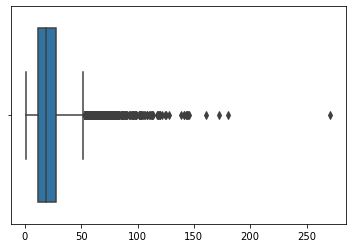

In [17]:
sns.boxplot(lengths)
plt.show()

In [18]:
MAX_SEQ_LENGTH = 100  

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [19]:
Y =  Y_padded

In [27]:
mod1 = FastText(X,size=300,window=5,min_count=5,seed=32,workers=multiprocessing.cpu_count(),batch_words=1)

In [28]:
mod2 = FastText(X,size=300,window=5,min_count=5,seed=102,workers=multiprocessing.cpu_count(),batch_words=1)

In [29]:
#word_frequency
w2c = dict()
for item in mod1.wv.vocab:
    w2c[item]=mod1.wv.vocab[item].count
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
# reverse output word and their frequency

In [30]:
def Stability(word,similar1,similar2):    
    overlap=0
    for i in range(len(similar1)):
        for j in range(len(similar2)):
            if similar1[i][0] == similar2[j][0]:
                overlap=overlap+1
    return overlap

In [32]:
X_embed = mod1.wv
X_embed2 = mod2.wv

In [51]:
start_time = time.process_time()
with open('test1.csv', 'a',errors='replace') as the_file:
    the_file.write('Word,Stability(%),Stability(%) IU,Frequency\n')
    for word in WordList:
            similar1=mod2.wv.most_similar(word[0], topn=10)
            similar2=mod1.wv.most_similar(word[0], topn=10)
            stab=Stability(word[0],similar1,similar2)
            the_file.write(word[0] + ',' + str(stab*10)+','+str(stab*100/(20-stab))+','+str(w2cSorted[word[0]])+'\n')
print (time.process_time() - start_time, "seconds")

331.0625 seconds


In [53]:
df=pd.read_csv('test1.csv')

In [54]:
df['Stability(%) IU'] = pd.to_numeric(df['Stability(%) IU'])
s = df['Stability(%) IU'].sum()
print(s)

981144.3214408199


In [55]:
df['Percentile Rank'] = df.Frequency.rank(pct = True)

In [56]:
df['Category'] = pd.cut(df['Percentile Rank'], bins = 5, labels = ["VL", "L", "M", "H", "VH"] )

In [57]:
df.head(100000)

,Word,Stability(%),Stability(%) IU,Frequency,Percentile Rank,Category
0,Pierre,80,66.666667,18.0,0.574812,M
1,61,30,17.647059,14.0,0.497069,M
2,years,90,81.818182,1363.0,0.991522,VH
3,old,80,66.666667,661.0,0.983096,VH
4,will,100,100.000000,3283.0,0.996467,VH
...,...,...,...,...,...,...
19103,Trecker,50,33.333333,6.0,0.151298,VL
19104,Murata,60,42.857143,5.0,0.054715,VL
19105,BroadBeach,60,42.857143,5.0,0.054715,VL
19106,McGill,100,100.000000,5.0,0.054715,VL


In [59]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = mod1[word]
    except KeyError:
        pass

<ipython-input-59-49ad5ec7ec42>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_weights[index, :] = mod1[word]


In [73]:
df1 = embedding_weights

In [60]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [61]:
Y_embed = to_categorical(Y)  # Y = tag, used one-hot encoding 

In [62]:
print(Y_embed.shape)

(72202, 100, 13)


In [ ]:
#split corpus into train and test

In [63]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_embed, test_size=TEST_SIZE, random_state=4)

In [ ]:
#split training into training and validation

In [64]:
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [65]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


In [ ]:
#Bi-directional LSTM

In [66]:
NUM_CLASSES = Y_embed.shape[2]

In [67]:

NUM_CLASSES

13

In [68]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(50, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [70]:
sum(embedding_weights[1])/VOCABULARY_SIZE

-0.00013278232344665386

In [71]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [75]:
bidirect_training = bidirect_model.fit(X_train, Y_train,
                                       batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))


Epoch 1/10
408/408 [==============================] - 379s 929ms/step - loss: 0.1554 - acc: 0.9714 - val_loss: 0.0308 - val_acc: 0.9904
Epoch 2/10
408/408 [==============================] - 446s 1s/step - loss: 0.0235 - acc: 0.9925 - val_loss: 0.0211 - val_acc: 0.9931
Epoch 3/10
408/408 [==============================] - 433s 1s/step - loss: 0.0162 - acc: 0.9947 - val_loss: 0.0183 - val_acc: 0.9940
Epoch 4/10
408/408 [==============================] - 422s 1s/step - loss: 0.0129 - acc: 0.9958 - val_loss: 0.0172 - val_acc: 0.9943
Epoch 5/10
408/408 [==============================] - 345s 846ms/step - loss: 0.0107 - acc: 0.9965 - val_loss: 0.0167 - val_acc: 0.9945
Epoch 6/10
408/408 [==============================] - 361s 885ms/step - loss: 0.0090 - acc: 0.9970 - val_loss: 0.0166 - val_acc: 0.9946
Epoch 7/10
408/408 [==============================] - 377s 923ms/step - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0166 - val_acc: 0.9946
Epoch 8/10
408/408 [==============================] - 352

In [152]:
df = bidirect_model.weights[7]

In [160]:
df = np.array(df)


In [161]:
df2 = np.array(df2)

In [131]:
scipy.spatial.distance.cosine(df, df2) 

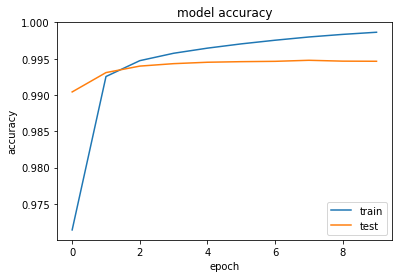

In [178]:
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [179]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 30s 88ms/step - loss: 0.0180 - acc: 0.9946
Loss: 0.017960190773010254,
Accuracy: 0.9945951700210571


In [ ]:
def getWordList(sentences,minCount):
    wordList = []
    count = Counter()
    for sentence in sentences:
        for word in sentence:
            count[word] += 1
    for word,c in count.items():
        if c >= minCount:
            wordList.append(word)
    return wordList

In [ ]:
WordList=getWordList(sentences,minCount=5) # for min frequency of a word which should be 5
#print(WordList)

In [ ]:
import itertools
ab=list(itertools.chain.from_iterable(sentences))
new_str =' '.join(ab)  
open('wikicleanPOS.txt', 'w').write(new_str) # writing clean text to new file

In [ ]:
model1 = FastText(sentences,size=100,window=5,min_count=5,seed=42,workers=multiprocessing.cpu_count(),batch_words=1) 

In [ ]:
#word_frequency
w2c = dict()
for item in model1.wv.vocab:
    w2c[item]=model1.wv.vocab[item].count
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
# reverse output word and their frequency

In [ ]:
def Stability(word,similar1,similar2):    
    overlap=0
    for i in range(len(similar1)):
        for j in range(len(similar2)):
            if similar1[i][0] == similar2[j][0]:
                overlap=overlap+1
    return overlap

In [ ]:
start_time = time.process_time()
with open('swikii.csv', 'a',errors='replace') as the_file:
    the_file.write('Word,Stability(%),Stability(%) IU,Frequency\n')
    for word in WordList:
        similar1=model1.wv.most_similar(word, topn=10)
        similar2=model2.wv.most_similar(word, topn=10)
        stab=Stability(word,similar1,similar2)
        the_file.write(word+','+str(stab*10)+','+str(stab*100/(20-stab))+','+str(w2cSorted[word])+'\n')
print (time.process_time() - start_time, "seconds")

In [ ]:
df = 